In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.rcParams['figure.dpi']= 100

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import cohen_kappa_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from gensim.models import Word2Vec

# plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

In [2]:
training_set = pd.read_pickle('training_features.pkl')

In [3]:
training_set.columns

Index(['essay_id', 'topic', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'target_score', 'rater1_domain2', 'rater2_domain2', 'topic2_target', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'matches', 'corrections',
       'corrected', 'tokens', 'lemma', 'pos', 'sents', 'ner', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj'],
      dtype='object')

In [4]:
training_set=training_set.drop(columns=['rater1_domain1','rater2_domain1', 'topic2_target', 'essay_id','rater3_domain1','rater1_domain2','rater2_domain2','rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4','rater1_trait5','rater1_trait6','rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4','rater2_trait5','rater2_trait6','rater3_trait1','rater3_trait2','rater3_trait3','rater3_trait4','rater3_trait5','rater3_trait6'])
training_set.sample()

,topic,essay,target_score,matches,corrections,corrected,tokens,lemma,pos,sents,ner,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
4477,3,The cyclist should have never taken the advice from the older men. The map would have been a lot...,2,[],0,The cyclist should have never taken the advice from the older men. The map would have been a lot...,"[The, cyclist, should, have, never, taken, the, advice, from, the, older, men, ., The, map, woul...","[the, cyclist, should, have, never, take, the, advice, from, the, old, man, ., the, map, would, ...","[DET, NOUN, AUX, AUX, ADV, VERB, DET, NOUN, ADP, DET, ADJ, NOUN, PUNCT, DET, NOUN, AUX, AUX, AUX...","[The cyclist should have never taken the advice from the older men., The map would have been a l...",[],0.706244,76,55,37,6,0,1,0,0,0,0,0,0,0,0,0,0,0,13,3,8,10,4,3,7,0,0,1,0


## Scale scores and normalize it

In [5]:
score_ranges = {
    1: (2, 12),
    2: (1, 6),
    3: (0, 3),
    4: (0, 3),
    5: (0, 4),
    6: (0, 4),
    7: (0, 30),
    8: (0, 60)
}

def normalize_score(row):
    topic = row['topic']
    score = row['target_score']
    min_score, max_score = score_ranges[topic]
    
    normalized = (score - min_score) / (max_score - min_score)
    
    scaled = normalized * 9 + 1
    return round(scaled)

training_set['normalized_target_score'] = training_set.apply(normalize_score, axis=1)

In [6]:
training_set.sample(10)

,topic,essay,target_score,matches,corrections,corrected,tokens,lemma,pos,sents,ner,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj,normalized_target_score
545,1,"Dear Newspaper, Computers are not something to be afraid of. They help many people in different ...",8,"[Offset 378, length 4, Rule ID: EN_CONTRACTION_SPELLING\nMessage: Possible spelling mistake foun...",10,"Dear Newspaper, Computers are not something to be afraid of. They help many people in different ...","[Dear, Newspaper, ,, Computers, are, not, something, to, be, afraid, of, ., They, help, many, pe...","[Dear, Newspaper, ,, computer, be, not, something, to, be, afraid, of, ., they, help, many, peop...","[PROPN, PROPN, PUNCT, NOUN, AUX, PART, PRON, PART, AUX, ADJ, ADP, PUNCT, PRON, VERB, ADJ, NOUN, ...","[Dear Newspaper, Computers are not something to be afraid of., They help many people in differen...","[Dear Newspaper, today, one, Millions, each day]",0.950453,449,214,244,24,5,24,3,10,11,1,1,0,1,0,0,0,0,98,24,42,63,16,10,29,4,1,18,1,6
11751,7,"I think patient is when some one is able to wait and not complain. I was never patient, so here ...",16,"[Offset 24, length 8, Rule ID: ANY_BODY\nMessage: Did you mean “someone”?\nSuggestion: someone\n...",17,"I think patient is when someone is able to wait and not complain. I was never patient, so here i...","[I, think, patient, is, when, someone, is, able, to, wait, and, not, complain, ., I, was, never,...","[I, think, patient, be, when, someone, be, able, to, wait, and, not, complain, ., I, be, never, ...","[PRON, VERB, ADJ, AUX, SCONJ, PRON, AUX, ADJ, PART, VERB, CCONJ, PART, VERB, PUNCT, PRON, AUX, A...","[I think patient is when someone is able to wait and not complain., I was never patient, so here...","[One day, first, minutes, the days, first, first, about @NUM5 hour and a half, @NUM7 minutes]",0.928123,454,181,218,28,8,15,4,0,0,0,5,0,0,0,0,0,0,77,14,69,60,17,35,35,9,1,14,1,6
5189,3,The features of the setting affect the cyclist in many ways. One feature of the setting was the ...,1,"[Offset 172, length 5, Rule ID: COMMA_PARENTHESIS_WHITESPACE\nMessage: Put a space after the com...",1,The features of the setting affect the cyclist in many ways. One feature of the setting was the ...,"[The, features, of, the, setting, affect, the, cyclist, in, many, ways, ., One, feature, of, the...","[the, feature, of, the, setting, affect, the, cyclist, in, many, way, ., one, feature, of, the, ...","[DET, NOUN, ADP, DET, NOUN, VERB, DET, NOUN, ADP, ADJ, NOUN, PUNCT, NUM, NOUN, ADP, DET, NOUN, A...","[The features of the setting affect the cyclist in many ways., One feature of the setting was th...",[One],0.816727,60,44,37,5,1,1,0,0,0,0,0,0,0,0,0,0,0,17,2,6,8,0,1,9,0,1,0,0,4
9994,6,The Empire State Building is known for its great size & distinctive shape in New York City's @CA...,4,"[Offset 351, length 3, Rule ID: SENTENCE_WHITESPACE\nMessage: Add a space between sentences.\nSu...",4,The Empire State Building is known for its great size & distinctive shape in New York City's @CA...,"[The, Empire, State, Building, is, known, for, its, great, size, &, distinctive, shape, in, New,...","[the, Empire, State, Building, be, know, for, its, great, size, &, distinctive, shape, in, New, ...","[DET, PROPN, PROPN, PROPN, AUX, VERB, ADP, PRON, ADJ, NOUN, CCONJ, ADJ, NOUN, ADP, PROPN, PROPN,...",[The Empire State Building is known for its great size & distinctive shape in New York City's @C...,"[The Empire State Building, New York City's, New York, U.S., the German Hindenburg, the Empire S...",0.868152,365,187,202,11,7,16,0,0,7,0,2,0,0,0,0,0,0,72,29,17,31,8,22,40,20,0,7,0,10
4736,3,The features of the setting affect the cyclist in many ways. One way is that if its hot and you...,1,"[Offset 80, length 4, Rule ID: MORFOLOGIK_RULE_EN_US\nMessage: Possible spelling mistake 

In [7]:
training_set = training_set.drop(columns=['topic'])

## Stem the essays

In [8]:
import re
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
len(stop_words) #finding stop words

from nltk.stem.porter import PorterStemmer
snow = nltk.stem.SnowballStemmer('english')

In [9]:
def snowball_stemming(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [snow.stem(word) for word in text if not word in stopwords.words('english')]
    return ' '.join(text)

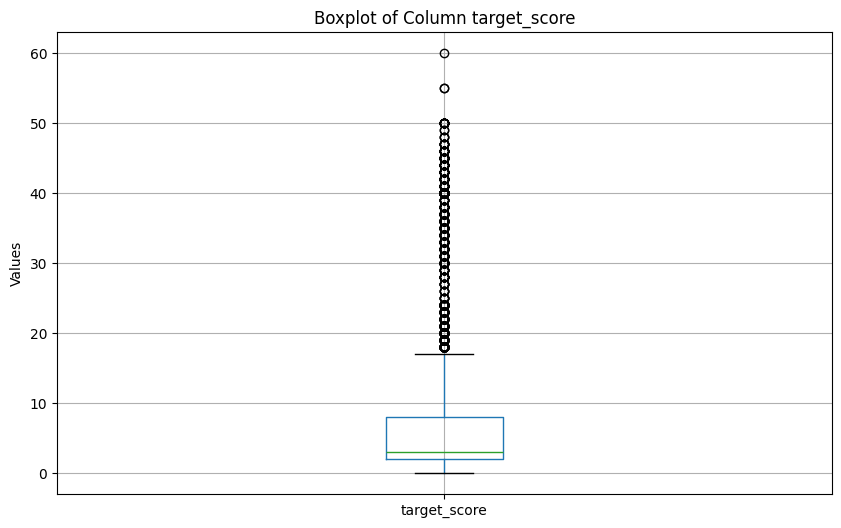

In [10]:
plt.figure(figsize=(10, 6))
training_set.boxplot(column=["target_score"])
plt.title('Boxplot of Column target_score')
plt.ylabel('Values')
plt.show()

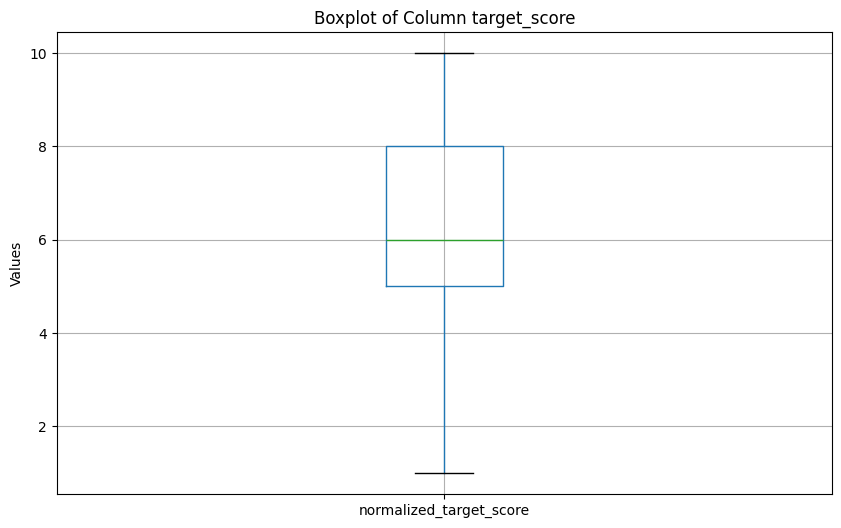

In [11]:
plt.figure(figsize=(10, 6))
training_set.boxplot(column=["normalized_target_score"])
plt.title('Boxplot of Column target_score')
plt.ylabel('Values')
plt.show()

In [12]:
training_set["normalized_target_score"].value_counts()

normalized_target_score
6     3519
7     2104
8     2074
4     1427
10    1356
5     1183
3      738
1      452
9      111
2       12
Name: count, dtype: int64

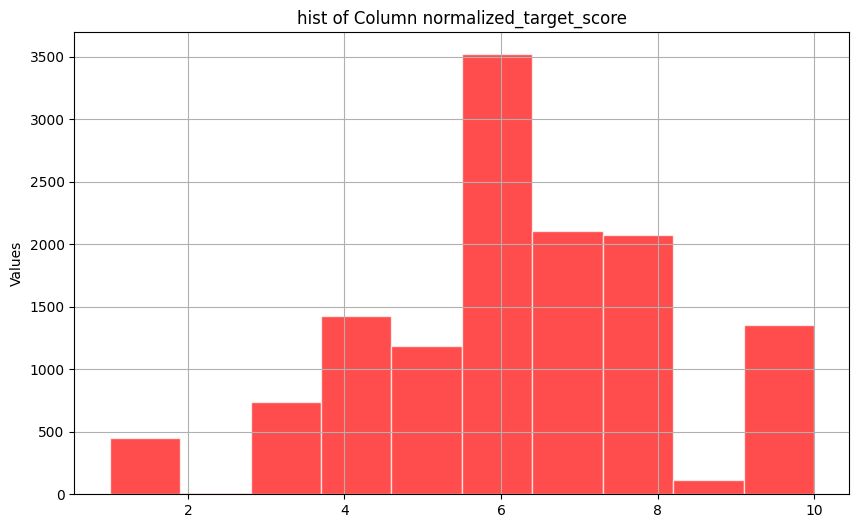

In [13]:
plt.figure(figsize=(10, 6))
training_set["normalized_target_score"].hist(
                            color ='red',
                            edgecolor = "white",
                            alpha = 0.7)
plt.title('hist of Column normalized_target_score')
plt.ylabel('Values')
plt.show()

In [14]:
training_set['clean_essay'] = training_set['corrected'].apply(snowball_stemming)

In [15]:
from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text)

training_set['clean_essay_tokens'] = training_set['clean_essay'].apply(tokenize_text)

In [16]:
training_set.to_pickle('cleaned_training_spacy.pkl')

In [17]:
training_set.select_dtypes(include='number').columns

Index(['target_score', 'corrections', 'similarity', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj', 'normalized_target_score'], dtype='object')

In [18]:
numerical_features = [  'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

## Select Best Feature

In [19]:
X = training_set[numerical_features]
y = training_set.normalized_target_score.round()
best_features = SelectKBest(score_func=chi2, k = 10)
fit=best_features.fit(X,y)

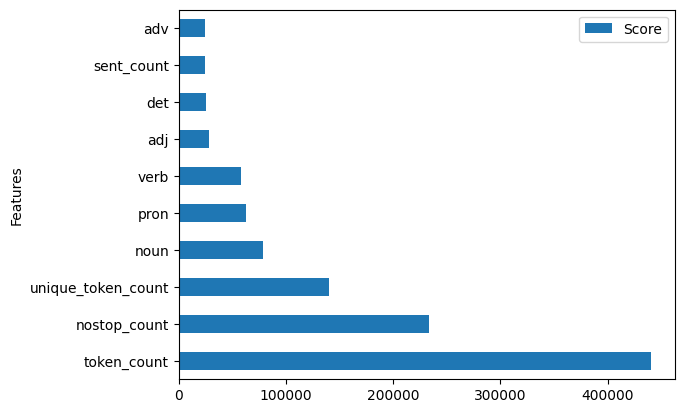

In [20]:
df_score=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,df_score],axis=1)
featureScores.columns=['Features','Score']
featureScores=featureScores.set_index('Features')
featureScores.nlargest(10,'Score').plot(kind='barh')
plt.show()

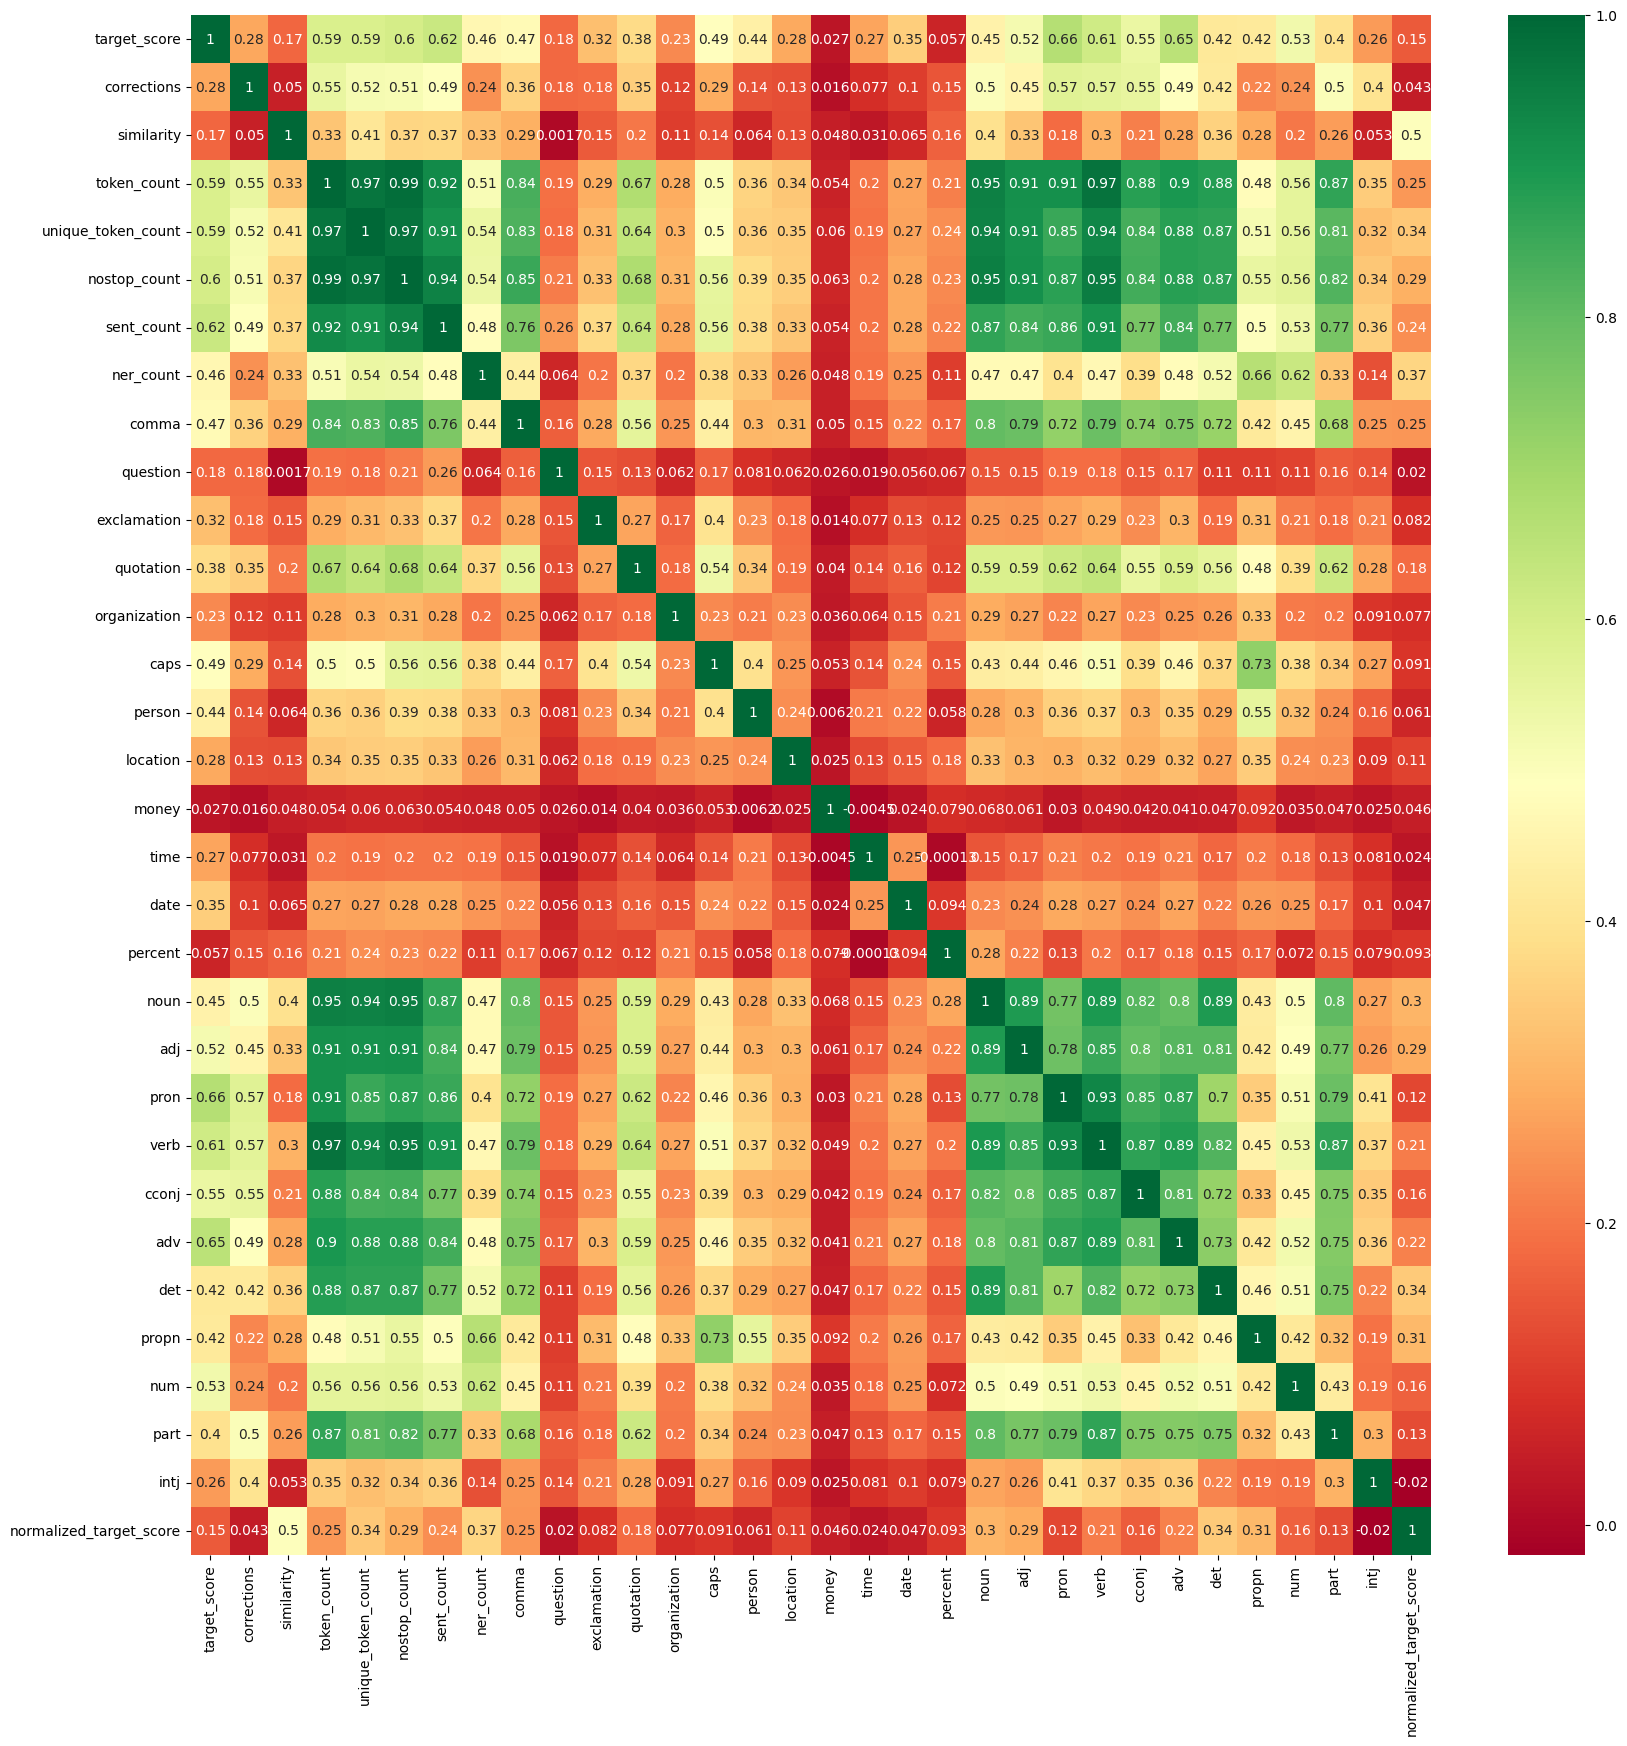

In [21]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = training_set.corr(numeric_only=True)
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(training_set[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [22]:
training_set.shape

(12976, 42)

In [23]:
training_set.describe()

,target_score,corrections,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,exclamation,quotation,organization,caps,person,location,money,time,date,percent,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj,normalized_target_score
count,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000,12976.000000
mean,6.800247,10.333231,0.814033,250.803329,118.196285,129.743604,13.255240,3.960003,8.701526,0.681027,0.345715,4.238826,0.272041,2.831689,0.468557,0.286606,0.025200,0.040999,0.144806,0.073829,43.258785,14.279054,29.202451,33.015644,8.592247,12.557182,20.475416,6.092401,1.211853,8.326141,0.332383,6.265875
std,8.970705,10.068739,0.090782,200.228105,70.656525,102.982605,11.347062,3.674337,9.713313,2.823064,1.380434,6.114721,1.260446,7.151832,2.160839,0.899801,0.377269,0.383292,0.711746,0.426599,33.935536,12.427146,28.803718,27.918889,8.457549,12.116530,14.530871,7.559339,1.873548,8.389395,0.916617,2.099688
min,0.000000,0.000000,0.028992,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,4.000000,0.769618,109.000000,67.000000,56.000000,5.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,9.000000,14.000000,3.000000,4.000000,10.000000,1.000000,0.000000,2.000000,0.000000,5.000000
50%,3.000000,7.000000,0.829416,183.000000,101.000000,98.000000,9.000000,3.000000,5.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,11.000000,19.000000,23.000000,6.000000,9.000000,17.000000,4.000000,1.000000,5.000000,0.000000,6.000000
75%,8.000000,14.000000,0.878419,347.000000,154.000000,176.000000,18.000000,6.000000,12.000000,0.000000,0.000000,6.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,19.000000,41.000000,46.000000,12.000000,17.000000,27.000000,8.000000,2.000000,12.000000,0.000000,8.000000
max,60.000000,124.000000,1.000000,1249.000000,503.000000,738.000000,114.000000,32.000000,74.000000,138.000000,27.000000,105.000000,40.000000,134.000000,70.000000,13.000000,23.000000,11.000000,16.000000,8.000000,261.000000,98.000000,221.000000,180.000000,70.000000,86.000000,106.000000,120.000000,22.000000,59.000000,33.000000,10.000000


In [24]:
X = training_set[numerical_features]
y = training_set["normalized_target_score"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
def test_metrics(y_test, predictions):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    print("Mean Squared Error:", mse)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    print("Mean Absolute Error:", mae)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:", rmse)
    
    y_pred = np.around(predictions)

    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))

    acc = accuracy_score(y_test.values,y_pred)
    print("acc Score: {}".format(acc))

    # Calculate accuracy within a tolerance range
    tolerance = 1  # Define the tolerance range
    correct_within_tolerance = np.sum(np.abs(y_test - predictions) <= tolerance)
    total_samples = len(y_test)
    accuracy_within_tolerance = correct_within_tolerance / total_samples
    print("Accuracy within ±{} point(s): {:.2f}%".format(tolerance, accuracy_within_tolerance * 100))
    

## XGBoost

BaseLine Model Using Numerical Features only

In [28]:
model = xgb.XGBRegressor( 
                         colsample_bytree = 0.3, 
                         learning_rate = 0.1, 
                         max_depth = 7, 
                         alpha = 10, 
                         n_estimators = 100)

In [29]:
model.fit(X_train, y_train)

predictions = model.predict(X_test)

test_metrics(y_test, predictions)

Mean Squared Error: 1.8772026878593606
Mean Absolute Error: 1.0181683390092777
Root Mean Squared Error: 1.3701104655681455
Kappa Score: 0.7224159273024793
acc Score: 0.336286594761171
Accuracy within ±1 point(s): 60.67%


## XGBoost with TFIDF

Using TFIDF to train the model on the corrected essays (not the cleaned ones) only

In [30]:
texts = training_set['corrected']

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, y, test_size=0.2, random_state=42)

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [31]:
model = xgb.XGBRegressor()
model.fit(X_train, labels_train)

predictions = model.predict(X_test)

test_metrics(y_test, predictions)

Mean Squared Error: 1.8404825019099147
Mean Absolute Error: 1.0119846217759034
Root Mean Squared Error: 1.3566438375306595
Kappa Score: 0.7409896483854699
acc Score: 0.33859784283513095
Accuracy within ±1 point(s): 60.09%


Using TFIDF to train the model on the cleaned essays only

In [32]:
texts = training_set['clean_essay']

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, y, test_size=0.2, random_state=42)

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [33]:
model = xgb.XGBRegressor()
model.fit(X_train, labels_train)

predictions = model.predict(X_test)

test_metrics(y_test, predictions)

Mean Squared Error: 1.7925112174667508
Mean Absolute Error: 1.0008426449607444
Root Mean Squared Error: 1.338846973132759
Kappa Score: 0.7480942056069988
acc Score: 0.3447611710323575
Accuracy within ±1 point(s): 60.48%


## XGBoost with Word2Vec

BaseLine Model Using Numerical Features And word2vec of cleaned essays

In [34]:
tokenized_essays = training_set['clean_essay_tokens']
X_numeric = training_set[numerical_features]
y = training_set['normalized_target_score']

word2vec_model = Word2Vec(sentences=tokenized_essays, vector_size=300, window=5, min_count=1, workers=4)
word2vec_model.init_sims(replace=True)
word2vec_model.save('word2vec_model.model')

def get_doc_embedding(tokens):
    embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

C:\Users\hm7al\AppData\Local\Temp\ipykernel_8912\3563211777.py:6: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  word2vec_model.init_sims(replace=True)
destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


In [35]:
X_word_embeddings = tokenized_essays.apply(get_doc_embedding).tolist()

X_combined = np.hstack([X_numeric.values, np.array(X_word_embeddings)])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [36]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 12, alpha = 10, n_estimators = 100)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train, y_train,
    eval_metric="rmse",
    eval_set=eval_set,
    verbose=True
)

c:\Users\hm7al\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.96107	validation_1-rmse:1.98422
[1]	validation_0-rmse:1.83850	validation_1-rmse:1.88411
[2]	validation_0-rmse:1.72369	validation_1-rmse:1.78884
[3]	validation_0-rmse:1.61870	validation_1-rmse:1.70718
[4]	validation_0-rmse:1.53087	validation_1-rmse:1.64697
[5]	validation_0-rmse:1.44690	validation_1-rmse:1.58399
[6]	validation_0-rmse:1.37226	validation_1-rmse:1.53089
[7]	validation_0-rmse:1.30528	validation_1-rmse:1.48597
[8]	validation_0-rmse:1.24452	validation_1-rmse:1.44717
[9]	validation_0-rmse:1.19050	validation_1-rmse:1.41398
[10]	validation_0-rmse:1.14111	validation_1-rmse:1.38575
[11]	validation_0-rmse:1.09739	validation_1-rmse:1.36011
[12]	validation_0-rmse:1.05866	validation_1-rmse:1.34046
[13]	validation_0-rmse:1.02081	validation_1-rmse:1.32438
[14]	validation_0-rmse:0.98717	validation_1-rmse:1.31034
[15]	validation_0-rmse:0.95702	validation_1-rmse:1.29816
[16]	validation_0-rmse:0.92963	validation_1-rmse:1.28891
[17]	validation_0-rmse:0.90133	validation

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [37]:
p = model.predict(X_test)
test_metrics(y_test, p)

Mean Squared Error: 1.4757612195640804
Mean Absolute Error: 0.8747793099224476
Root Mean Squared Error: 1.214809128861024
Kappa Score: 0.7938286425453681
acc Score: 0.40755007704160245
Accuracy within ±1 point(s): 67.14%


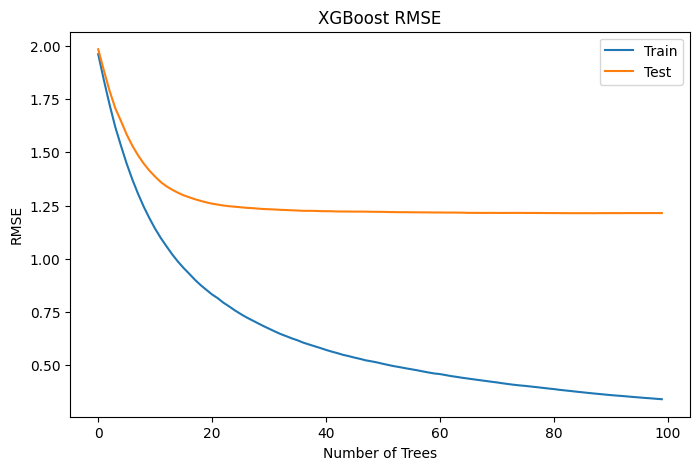

In [38]:
# Extract evaluation results
results = model.evals_result()

# Plotting the learning curve
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.xlabel('Number of Trees')
plt.show()

# Save The Model

In [39]:
import joblib

joblib.dump(model, "xgb_word2vec_model") 

['xgb_word2vec_model']

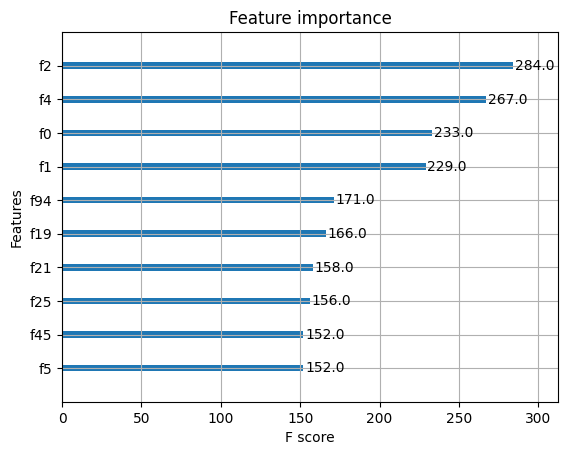

In [40]:
xgb.plot_importance(model, max_num_features=10)
plt.show()